# **_DESARROLLO LABORATORIO 20_**

In [45]:
#Just in Case
import warnings
warnings.filterwarnings('ignore')

#Importando las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import model_evaluation_utils as meu

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTETomek
from sklearn.metrics import confusion_matrix, auc, roc_curve
from sklearn.preprocessing import label_binarize
from mlxtend.plotting import plot_decision_regions
from sklearn.naive_bayes import GaussianNB       #Para hacer un modelo Naive-Bayes
from sklearn.svm import SVC                      #Para hacer un modelo de Máquina de Soporte Vectorial

from math import log

In [2]:
# Estableciendo mi directorio de trabajo
os.chdir('D:\Social Data Consulting\Python for Data Science\data')

In [3]:
miArchivo="HTRU_2.csv"
df_HTRU2=pd.read_csv(miArchivo,sep=',')
df_HTRU2.head()

,Med_perfil_int,Desviacion_est_prf_int,Exceso_cur_prf_int,Torcedura_prf_int,Med_curv_DM-SNR,Desviacion_est_cur,Exc_curt_DM-SNR,Torcedura_cur_DM-SNR,Clase_HTRU
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


### **_1.Frecuencia de Observaciones del TARGET._**

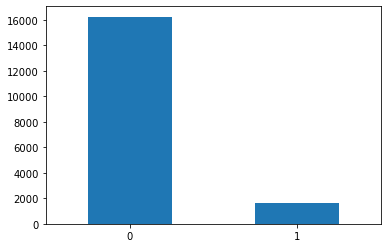

In [4]:
pd.value_counts(df_HTRU2.Clase_HTRU).plot(kind='bar',rot=0)

### **_2. Graficos de correlacion de Pearson de los predictores._**

In [18]:
columnas=['Med_perfil_int', 'Desviacion_est_prf_int', 'Exceso_cur_prf_int',
       'Torcedura_prf_int', 'Med_curv_DM-SNR', 'Desviacion_est_cur',
       'Exc_curt_DM-SNR', 'Torcedura_cur_DM-SNR']
target=['Clase_HTRU']

In [58]:
df_HTRU2[columnas].corr(method='pearson')

,Med_perfil_int,Desviacion_est_prf_int,Exceso_cur_prf_int,Torcedura_prf_int,Med_curv_DM-SNR,Desviacion_est_cur,Exc_curt_DM-SNR,Torcedura_cur_DM-SNR
Med_perfil_int,1.000000,-0.000597,-0.039351,-0.031990,-0.013739,-0.010734,0.009607,0.008601
Desviacion_est_prf_int,-0.000597,1.000000,0.011141,0.007630,0.006360,0.011624,-0.009918,-0.006380
Exceso_cur_prf_int,-0.039351,0.011141,1.000000,0.945729,0.414368,0.432880,-0.341209,-0.214491
Torcedura_prf_int,-0.031990,0.007630,0.945729,1.000000,0.412056,0.415140,-0.328843,-0.204782
Med_curv_DM-SNR,-0.013739,0.006360,0.414368,0.412056,1.000000,0.796555,-0.615971,-0.354269
Desviacion_est_cur,-0.010734,0.011624,0.432880,0.415140,0.796555,1.000000,-0.809786,-0.575800
Exc_curt_DM-SNR,0.009607,-0.009918,-0.341209,-0.328843,-0.615971,-0.809786,1.000000,0.923743
Torcedura_cur_DM-SNR,0.008601,-0.006380,-0.214491,-0.204782,-0.354269,-0.575800,0.923743,1.000000


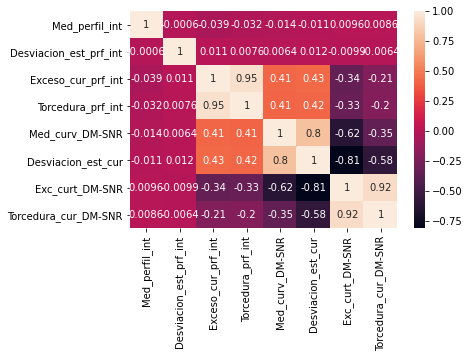

In [59]:
sns.heatmap(df_HTRU2[columnas].corr(method='pearson'),annot=True)
plt.show()

### **_3.Probabilidades de prediccion._**

In [13]:
X=df_HTRU2.iloc[:,0:df_HTRU2.shape[1]-1].values
y=df_HTRU2.iloc[:,df_HTRU2.shape[1]-1].values

In [14]:
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,stratify=y,random_state=2020)

### Balanceo de la target 

In [15]:
smt=SMOTETomek(sampling_strategy=0.7, random_state=2020)
xtrain_smt,ytrain_smt=smt.fit_resample(xtrain,ytrain)

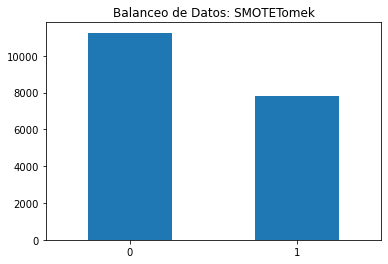

In [16]:
pd.value_counts(ytrain_smt).plot(kind='bar',rot=0)
plt.title('Balanceo de Datos: SMOTETomek')
plt.show()

In [19]:
data_xtrain=pd.DataFrame(xtrain_smt,columns=columnas)
data_ytrain=pd.DataFrame(ytrain_smt,columns=target)
data_train=pd.concat([data_xtrain,data_ytrain],axis=1)
data_train.head()

,Med_perfil_int,Desviacion_est_prf_int,Exceso_cur_prf_int,Torcedura_prf_int,Med_curv_DM-SNR,Desviacion_est_cur,Exc_curt_DM-SNR,Torcedura_cur_DM-SNR,Clase_HTRU
0,117.765625,46.683356,0.319175,-0.143651,1.853679,14.755006,10.773976,138.971545,0
1,132.640625,50.282131,-0.135232,-0.266753,1.311873,10.694006,14.443795,285.444475,0
2,96.554688,53.000561,0.809315,0.539038,4.046823,24.366237,7.722320,63.454033,1
3,141.312500,52.446662,-0.193099,-0.208575,2.249164,17.624895,9.335137,95.961399,0
4,140.234375,45.116946,-0.061888,0.225694,1.879599,16.687183,10.615140,125.348308,0


In [21]:
data_xtest=pd.DataFrame(xtest,columns=columnas)
data_ytest=pd.DataFrame(ytest,columns=target)
data_test=pd.concat([data_xtest,data_ytest],axis=1)
data_test.head()

,Med_perfil_int,Desviacion_est_prf_int,Exceso_cur_prf_int,Torcedura_prf_int,Med_curv_DM-SNR,Desviacion_est_cur,Exc_curt_DM-SNR,Torcedura_cur_DM-SNR,Clase_HTRU
0,8.156250,27.129446,7.856370,62.868531,128.375418,67.902648,-0.177335,-0.673351,1
1,115.320312,45.561588,0.299415,0.642796,1.788462,16.343089,10.588251,122.003890,0
2,121.562500,45.859628,0.066315,0.137466,2.341137,16.162139,9.623207,111.312390,0
3,110.242188,44.725508,0.431287,0.734862,3.200669,20.669437,7.851218,69.931084,0
4,91.187500,44.702096,0.305570,0.654166,1.614548,10.753443,13.704335,271.774100,0


In [22]:
#Instanciamos un objeto de clase GaussianNB
clf=GaussianNB()

In [24]:
#Hacemos que nuestro modelo aprenda de los datos balanceados
clf.fit(xtrain_smt,ytrain_smt)

GaussianNB()

In [37]:
#Calculandremos los Ypredichos
ypredichos_train=clf.predict(xtrain_smt)
ypredichos_test=clf.predict(xtest)

#### Data de entrenamiento

In [30]:
proba_train= clf.predict_proba(xtrain_smt)
prob_df_train=pd.DataFrame(proba_train[:,1],columns=['prob y=1'])

In [51]:
punto_corte=0.5
prob_df_train['prediccion']=np.where(prob_df_train['prob y=1']>punto_corte,1,0)
prob_df_train.head()

,prob y=1,prediccion
0,2.373274e-09,0
1,2.106289e-18,0
2,1.160739e-05,0
3,1.712392e-07,0
4,6.754550e-09,0


In [43]:
proba_test= clf.predict_proba(xtest)
prob_df_test=pd.DataFrame(proba_test[:,1],columns=['prob y=1'])

In [44]:
punto_corte=0.5
prob_df_test['prediccion']=np.where(prob_df_test['prob y=1']>punto_corte,1,0)
prob_df_test.head()

,prob y=1,prediccion
0,1.000000e+00,1
1,1.058449e-08,0
2,3.594379e-08,0
3,2.333821e-06,0
4,4.217411e-17,0


### **_4. Matriz de Confusión._**

In [39]:
label_name=[0,1]

#### Data de entrenamiento

In [56]:
meu.display_confusion_matrix(ytrain_smt,ypredichos_train,classes=label_name)

       0     1
0  10706   550
1   1534  6307


In [53]:
meu.display_model_performance_metrics(ytrain_smt,ypredichos_train,classes=label_name)

Model Performance metrics:
------------------------------
Accuracy: 0.8909
Precision: 0.8932
Recall: 0.8909
F1 Score: 0.8895

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     11256
           1       0.92      0.80      0.86      7841

    accuracy                           0.89     19097
   macro avg       0.90      0.88      0.88     19097
weighted avg       0.89      0.89      0.89     19097


Prediction Confusion Matrix:
------------------------------
       0     1
0  10706   550
1   1534  6307


#### Data de testeo

In [55]:
meu.display_confusion_matrix(ytest,ypredichos_test,classes=label_name)

      0    1
0  4643  235
1    77  415


In [54]:
meu.display_model_performance_metrics(ytest,ypredichos_test,classes=label_name)

Model Performance metrics:
------------------------------
Accuracy: 0.9419
Precision: 0.9521
Recall: 0.9419
F1 Score: 0.9454

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      4878
           1       0.64      0.84      0.73       492

    accuracy                           0.94      5370
   macro avg       0.81      0.90      0.85      5370
weighted avg       0.95      0.94      0.95      5370


Prediction Confusion Matrix:
------------------------------
      0    1
0  4643  235
1    77  415


### **_5. Generar el grafico de la curva ROC para datos de entrenamiento y testeo._**

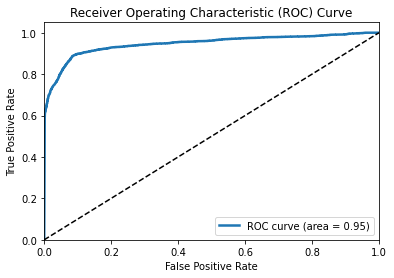

In [40]:
meu.plot_model_roc_curve(clf,xtrain_smt,ytrain_smt,class_names=label_name)

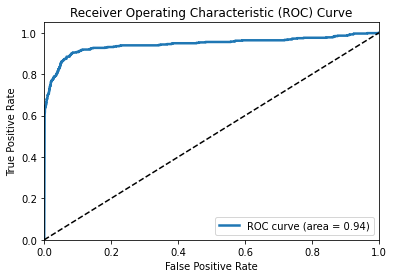

In [52]:
meu.plot_model_roc_curve(clf,xtest,ytest,class_names=label_name)